#驗證Nvidia GPU及CUDA版本
確認運行環境 
GPU每次配置可能不同，可能為 K80, T4, P100，記憶體大小可能會影響到後續訓練時Patch Size大小。  
若想要好一點的GPU則重覆斷開連線(Ctrl+M)再重新連線，直到出現期望的GPU出現，再進行下一個步驟。  

In [ ]:
!nvidia-smi
!/usr/local/cuda/bin/nvcc --version

Wed Jun  7 10:20:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#連接Google Drvie
建立捷徑 /my_drive 指向已掛載之Google Drvie (/content/drive/MyDrive/) 

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
!ln -s /content/drive/MyDrive/Colab/final/ /my_drive
!ls
!ls /my_drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ln: failed to create symbolic link '/my_drive/final': File exists
 3rdparty			   Makefile
 backup				  'my_obj (1).data'
 bad_label.list			   my_obj.data
 bad.list			   my_obj.names
 build				   my_train.txt
 build.ps1			   my_val.txt
 cfg				   my_yolov4-tiny-custom.cfg
 chart_my_yolov4-tiny-custom.png   net_cam_v3.sh
 chart.png			   net_cam_v4.sh
 cmake				   obj
 CMakeLists.txt			   predictions.jpg
 darknet			   README.md
 DarknetConfig.cmake.in		   results
 darknet_images.py		   scripts
 darknet.py			   src
 darknet_video.py		   vcpkg.json
 data				   vcpkg.json.opencv23
 image_yolov3.sh		   video_yolov3.sh
 image_yolov4.sh		   video_yolov4.sh
 include			   yolov4-tiny.conv.29
 json_mjpeg_streams.sh		   yolov4-tiny.weights
 LICENSE
darknet		my_train.txt		   train
final		my_val.txt		   yolov4-tiny
images		my_yolov4-tiny-custom.cfg  yolov4-tiny.conv.29
my_d

#3. 下載darknet及Yolov4-tiny預訓練權重檔

In [ ]:
# 下載darknet
!git clone https://github.com/AlexeyAB/darknet

#4. 修改Makefile參數
將GPU, CUDNN, CUDNN_HALF, OPENCV設為可用  
GPU=0 --> GPU=1  
CUDNN=0 --> CUDNN=1  
CUDNN_HALF=0 --> CUDNN_HALF=1  
OPENCV=0 --> OPENCV=1

In [ ]:
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

#5. 編譯darknet

In [ ]:
!make

chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -rdynamic -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
  946 |                 float rgb[3];
      |                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
 1147 |             if (iteration_old == 0)
   

#6. 準備自定義預訓練權重檔、資料集及相關參數檔

參數檔包含下列內容，可依資料集實際內容進行修改。

*    my_obj.data （物件資料設定，含物件類別、訓練驗證路徑、備份權重路徑）
*    my_obj.names （物件類別名稱，每一列為一個類別名稱）
*    my_yolov4-tiny-custom.cfg （設定模型組態）
*    my_train.txt （訓練內容檔案名稱，取資料集前80組，可自行定義）
*    my_valid.txt （驗證內容檔案名稱，取資料集後20組，可自行定義）

其中第3項my_yolov4-tiny-custom.cfg是從/darknet/cfg/yolov4-tiny-custom.cfg須修改而得，修改內容如下，須依自定義資料集內容而定。
*    line 6 : batch=64 # 可依顯卡記憶體調整
*    line 7 : subdivisions=1 # 可依顯卡記憶體調整
*    line 8 : width=416 # 須為32的倍數
*    line 9 : height=416 # 須為32的倍數
*    line 20 : max_batches=6000 # 類別數量(classes)x2000，目前類別數量為5
*    line 22 : steps=4800,5400 # 為max_batch值的 80%, 90%
*    line 212, 263 : filter=255 # 為(classes+5)x3
*    line 220, 269 : classes=3 # 物件類別數量 

最後將相關參數檔複製到/darknet對應路徑下。  

In [ ]:
#回到使用者根目錄
%cd /content
# 下載yolov4-tiny自定義權重檔yolov4-tiny.conv.29(18.8MB)
!wget -N https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.conv.29
# 下載資料集和相關參數檔
#!git clone https://github.com/OmniXRI/Yolov4-tiny_Colab_User_Datasets
#!ls
# 相關參數到對應路徑下
!cp /my_drive/my_yolov4-tiny-custom.cfg darknet/cfg
#!ls darknet/cfg
!cp /my_drive/my_obj.names darknet/data
!cp /my_drive/my_obj.data darknet/data
!cp /my_drive/my_train.txt darknet/data
!cp /my_drive/my_val.txt darknet/data
#!ls darknet/data
# 將資料集解壓縮到指定路徑
!mkdir darknet/data/my_data
!unzip /my_drive/my_dataset.zip -d darknet/data/my_data
#!ls darknet/data/my_data/

#8. 開始訓練  
##8.1 正常重新訓練  
指定.data, .cfg, 預訓練參數檔並開始訓練，如需記錄平均精確度mAP(mean average precisions)可加上參數 -map。如果訓練過程很容易無故中止則建議移除參數 -map。  

訓練期間會記錄Loss並繪成圖表(darknet/chart_my_yolov4-tiny-custom.png)，可隨時重新開啟觀察訓練成果。  

每隔1000次會自動備份一次權重檔到雲端硬碟/my_drive/yolov4-tiny下(根據my_obj.data中backup設定值)，檔名為my_yolov4-tiny_x000.weights (x為1~n)。  

訓練期間會自動產生my_yolov4-tiny_best.weights和my_yolov4-tiny_last.weights，完成訓練會產生my_yolov4-tiny_final.weights。  

這裡要注意雲端硬體要有足夠空間存放，否則空間不足時就無法備份權重值。

In [ ]:
%cd /content/darknet
!./darknet detector train data/my_obj.data cfg/my_yolov4-tiny-custom.cfg ../yolov4-tiny.conv.29 -map -dont_show

串流輸出內容已截斷至最後 5000 行。
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.401645), count: 60, class_loss = 0.823318, iou_loss = 0.145384, total_loss = 0.968702 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.584466), count: 302, class_loss = 3.719369, iou_loss = 17.974960, total_loss = 21.694330 
 total_bbox = 185251, rewritten_bbox = 0.771386 % 


 Tensor Cores are disabled until the first 3000 iterations are reached.
 (next mAP calculation at 1000 iterations) ]2;445/8000: loss=2.3 hours left=4.6
 445: 2.271898, 2.806274 avg loss, 0.000102 rate, 1.240831 seconds, 28480 images, 4.558921 hours left
Loaded: 1.539647 seconds - performance bottleneck on CPU or Disk HDD/SSD
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.373373), count: 60, class_loss = 0.837359, iou_loss = 0.136697, total_loss = 0.974056 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.55783

##8.2 重新接續執行訓練  
前一步驟有設定備份訓練過程的權重檔，若遇到執行到一半就斷線，此時可以從Google Drive中把最後一次權重檔 my_yolov4-tiny-custom_last.weights 複製到Colab darknet/backup下，再重新啟動訓練。

In [ ]:
!cp /my_drive/yolov4-tiny/my_yolov4-tiny-custom_last.weights backup/
!ls backup/

my_yolov4-tiny-custom_last.weights


In [ ]:
!./darknet detector train data/my_obj.data cfg/my_yolov4-tiny-custom.cfg backup/my_yolov4-tiny-custom_last.weights -map -dont_show

#9. 測試訓練結果  
1.   完成訓練後，可將結果權重檔my_yolov4-tiny-custom_final.weights複製到Colab虛擬機中。
2.   執行darknet物件偵測推論，指定 data, config, weight, image 所在位置，/Yolov4-tiny_Colab_User_Datasets下有test01.jpg和test02.jpg可供測試。
3.   顯示結果影像predictions.jpg

 3rdparty			   Makefile
 backup				  'my_obj (1).data'
 bad_label.list			   my_obj.data
 bad.list			   my_obj.names
 build				   my_train.txt
 build.ps1			   my_val.txt
 cfg				   my_yolov4-tiny-custom.cfg
 chart_my_yolov4-tiny-custom.png   net_cam_v3.sh
 chart.png			   net_cam_v4.sh
 cmake				   obj
 CMakeLists.txt			   predictions.jpg
 darknet			   README.md
 DarknetConfig.cmake.in		   results
 darknet_images.py		   scripts
 darknet.py			   src
 darknet_video.py		   vcpkg.json
 data				   vcpkg.json.opencv23
 image_yolov3.sh		   video_yolov3.sh
 image_yolov4.sh		   video_yolov4.sh
 include			   yolov4-tiny.conv.29
 json_mjpeg_streams.sh		   yolov4-tiny.weights
 LICENSE
 CUDA-version: 11080 (12000), cuDNN: 8.7.0, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 4.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output

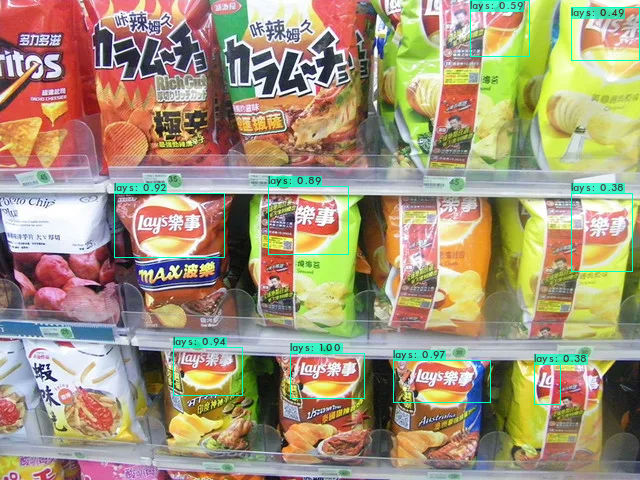

In [ ]:
!cp /my_drive/yolov4-tiny/my_yolov4-tiny-custom_last.weights ../
!ls
!./darknet detector test data/my_obj.data cfg/my_yolov4-tiny-custom.cfg ../my_yolov4-tiny-custom_last.weights /my_drive/test05.jpg

import cv2 # 導入OpenCV函式庫
from google.colab.patches import cv2_imshow # 導入Colab.patches函式庫

imgResult = cv2.imread('predictions.jpg') # 讀入結果影像
cv2_imshow(imgResult) # 顯示結果影像